# Prepare Project

Install required libraries either adding them one by one to the existing libaries or from a requirements.txt file.

In [ ]:
!pip install keras==2.3.1
!pip install tensorflow==1.15.0
!pip install keras_applications==1.0.8
!pip install image-classifiers==1.0.0
!pip install efficientnet==1.0.0
!pip install segmentation_models

In [ ]:
!pip install -r requirements.txt

# Main project

The training dataset contains 129 linescan images (infra-red images taken from an airplane) of bushfires in Victoria, Australia, during the first three months of 2019. There are also polygons showing where the fire is in each image, which have been hand-drawn by collaborators at the Country Fire Authority (CFA). These polygons are the ground truth that we should be able to recreate. There are an additional 5 linescan images, the test dataset, where the polygons showing the fire boundaries have not been provided.

Our task is to train a model or process which can produce a fire boundary for the remaining 5 linescans with no polygon.
All the linescan images (both the traning and test sets) are served via the Open Data Cube python library. The polygons are already available in the given environment.

## Import libraries and instantiate a datacube

In [1]:
%env SM_FRAMEWORK=tf.keras

env: SM_FRAMEWORK=tf.keras


In [2]:
import tensorflow as tf
from tensorflow import keras
import segmentation_models as sm
from segmentation_models.utils import set_trainable

Segmentation Models: using `tf.keras` framework.


In [3]:
import sys
import cv2
import math
import numpy as np
import pandas as pd
import geopandas as gpd

from datacube import Datacube
import matplotlib.pyplot as plt
from skimage.filters import try_all_threshold

from helper_functions import *
from dea_spatialtools import xr_rasterize

/env/lib/python3.6/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.7.2-CAPI-1.11.0 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [4]:
dc = Datacube(app="Getting started")

/env/lib/python3.6/site-packages/datacube/drivers/postgres/_connections.py:87: SADeprecationWarning: Calling URL() directly is deprecated and will be disabled in a future release.  The public constructor for URL is now the URL.create() method.
  username=username, password=password,


## Import variables

### Import input variable: Aerial Linescan Images

Firstly, let's query the datacube object to identify what linescans are available. We'll also sort them by ID to ensure they're ordered consistently for this guide.

In [5]:
linescan_datasets = dc.find_datasets(product='linescan')
linescan_datasets = sorted(linescan_datasets, key = lambda ds: (ds.center_time, ds.id))

sample = linescan_datasets[0]
print(sample)

print(f'\nNumber of linescan datasets: {len(linescan_datasets)}')

Dataset <id=5526d747-c6b7-50b8-b0b5-905ca28264ee product=linescan location=https://geoau.blob.core.windows.net/ey-gsa/linescan/ROSEDALE_P1_201901041439_MGA94_55.odc-dataset.json>

Number of linescan datasets: 134


The results stored in `linescan_datasets` are metadata which describe the various linescan files, including the filename (called the 'label'), extent, date and time of acquisition, and an ID number for that dataset. We need to load the dataset to actually read or view the data. The cell below loads a single linescan from the available list.

In [ ]:
ds = dc.load(product='linescan', id=linescan_datasets[23].id, output_crs='epsg:28355', resolution=(-10,10))

ds

In [ ]:
# Plot linescan example
ds.linescan.plot();

The "challenge1_train.csv" file lists the names of all the training linescans that are available.

In [6]:
train = pd.read_csv('resources/challenge1_train.csv', index_col='id')

print(f'\nNumber of training images: {len(train)}')
train.head()


Number of training images: 129


,label,dateTimeLocal,dateTimeUTC
id,,,
0,ROSEDALE_P1_201901041439_MGA94_55,4/01/2019 14:39,4/01/2019 3:39
1,ROSEDALE_1_P1_201901041446_MGA94_55,4/01/2019 14:46,4/01/2019 3:46
2,ROSEDALE_3_P1_201901041501_MGA94_55,4/01/2019 15:01,4/01/2019 4:01
3,POINT_H_62_P1_201901162128_MGA94_55,16/01/2019 21:28,16/01/2019 10:28
4,NUNNETT_73_P1_201901171134_MGA94_55,17/01/2019 11:34,17/01/2019 0:34


### Import Target Variable: Fire Map Polygons

Let's load and display the target dataset, which contains the ground-truth polygons.

In [7]:
vector_file = 'resources/fire_boundaries.shp'

gdf = gpd.read_file(vector_file)

print('Number of objects in geodataframe: ' + str(len(gdf)))
gdf.head().T

Number of objects in geodataframe: 976


,0,1,2,3,4
Source,Linescan,Linescan,Linescan,Linescan,Linescan
SourceName,aberfeldy west 200 p1_201901260955_mga94_55.jpg,aberfeldy west 200 p1_201901260955_mga94_55.jpg,aberfeldy west 200 p1_201901260955_mga94_55.jpg,aberfeldy west 214 p1_201901261750_mga94_55.jpg,aberfeldy west 214 p1_201901261750_mga94_55.jpg
Type,Initial ignition,Initial ignition,Initial ignition,Spot,Main run
dtString,2019/01/26 09:55:00.000,2019/01/26 09:55:00.000,2019/01/26 09:55:00.000,2019/01/26 17:50:00.000,2019/01/26 17:50:00.000
Comments,originally Latrobe 87 - Jericho - Jim Track,originally Latrobe 86 - Jericho - Thomson - Jo...,originally Latrobe 85 - Jericho - Cream Can Hill,originally Latrobe 87 - Jericho - Jim Track,originally Latrobe 87 - Jericho - Jim Track
dtUTC,2019-01-25 22:55:00,2019-01-25 22:55:00,2019-01-25 22:55:00,2019-01-26 06:50:00,2019-01-26 06:50:00
dtLocal,2019-01-26 09:55:00,2019-01-26 09:55:00,2019-01-26 09:55:00,2019-01-26 17:50:00,2019-01-26 17:50:00
ID,0,1,2,3,4
event,Latrobe86,Latrobe86,Latrobe86,Latrobe86,Latrobe86
geometry,"POLYGON ((431455.6047864075 5829806.836519156,...","POLYGON ((433874.4491466696 5827986.798174933,...","POLYGON ((430459.9135101112 5831285.491971598,...","POLYGON ((431937.3755649604 5829943.370969374,...","POLYGON ((431541.6507835893 5829804.025387563,..."


### Cleaning Up Polygon Dataset

Let's work on the string formatting first. The format is slightly different between the linescan label field and the polygon SourceName field. The white spaces have been replaced with underscores and the '.jpg' at the end of the filename has been removed, and its in upper case. To clean up the SourceName field in the polygon dataset, first we create a function and test it, and then apply it across the dataset. We also need to make sure we keep in mind that composite SourceNames don't have a '.jpg' at the end, and so should be treated slightly differently.

In [8]:
gdf['SourceNameClean'] = gdf.apply(lambda row: clean_name(row.SourceName), axis=1)
gdf.head().T

,0,1,2,3,4
Source,Linescan,Linescan,Linescan,Linescan,Linescan
SourceName,aberfeldy west 200 p1_201901260955_mga94_55.jpg,aberfeldy west 200 p1_201901260955_mga94_55.jpg,aberfeldy west 200 p1_201901260955_mga94_55.jpg,aberfeldy west 214 p1_201901261750_mga94_55.jpg,aberfeldy west 214 p1_201901261750_mga94_55.jpg
Type,Initial ignition,Initial ignition,Initial ignition,Spot,Main run
dtString,2019/01/26 09:55:00.000,2019/01/26 09:55:00.000,2019/01/26 09:55:00.000,2019/01/26 17:50:00.000,2019/01/26 17:50:00.000
Comments,originally Latrobe 87 - Jericho - Jim Track,originally Latrobe 86 - Jericho - Thomson - Jo...,originally Latrobe 85 - Jericho - Cream Can Hill,originally Latrobe 87 - Jericho - Jim Track,originally Latrobe 87 - Jericho - Jim Track
dtUTC,2019-01-25 22:55:00,2019-01-25 22:55:00,2019-01-25 22:55:00,2019-01-26 06:50:00,2019-01-26 06:50:00
dtLocal,2019-01-26 09:55:00,2019-01-26 09:55:00,2019-01-26 09:55:00,2019-01-26 17:50:00,2019-01-26 17:50:00
ID,0,1,2,3,4
event,Latrobe86,Latrobe86,Latrobe86,Latrobe86,Latrobe86
geometry,"POLYGON ((431455.6047864075 5829806.836519156,...","POLYGON ((433874.4491466696 5827986.798174933,...","POLYGON ((430459.9135101112 5831285.491971598,...","POLYGON ((431937.3755649604 5829943.370969374,...","POLYGON ((431541.6507835893 5829804.025387563,..."


We can now use the SourceNameClean field to join the polygon dataset to the linescan dataset, for those polygons where there is a direct match.

## Explore conventional approaches & filters

In order to extract meaningful information from the linescan images, we need to clean up the noise in the image and make the signal clearer. For this reason, we explore some traditional approaches in image analysis, such as manual and adaptive thresholding.

In [9]:
# Choose an image for segmentation
fname = linescan_datasets[23].metadata_doc['label']
src = dc.load(product='linescan', id=linescan_datasets[23].id, output_crs='epsg:28355', resolution=(-10,10))

print(f"There are {sum(gdf.SourceNameClean == fname)} polygons for linescan {fname}")

# Get the ground-truth mask
ob = gdf.loc[gdf.SourceNameClean == fname]
tgt = xr_rasterize(gdf=ob, da=src)

# Define image and mask
img = src.linescan.values[0]
true_mask = tgt.values

There are 3 polygons for linescan ABERFELDY_WEST_200_P1_201901260955_MGA94_55
Rasterizing to match xarray.DataArray dimensions (777, 1171)


Explore pixel intensity for manual thresholding.

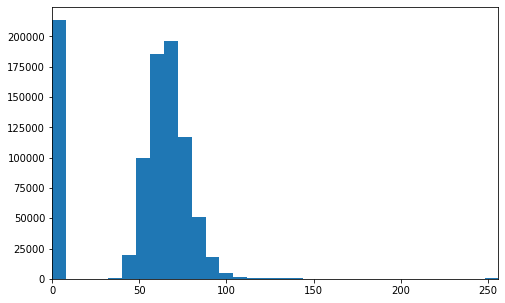

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

ax.hist(img.ravel(), bins=32, range=[0, 256])
ax.set_xlim(0, 256);

Try various thresholding methods.

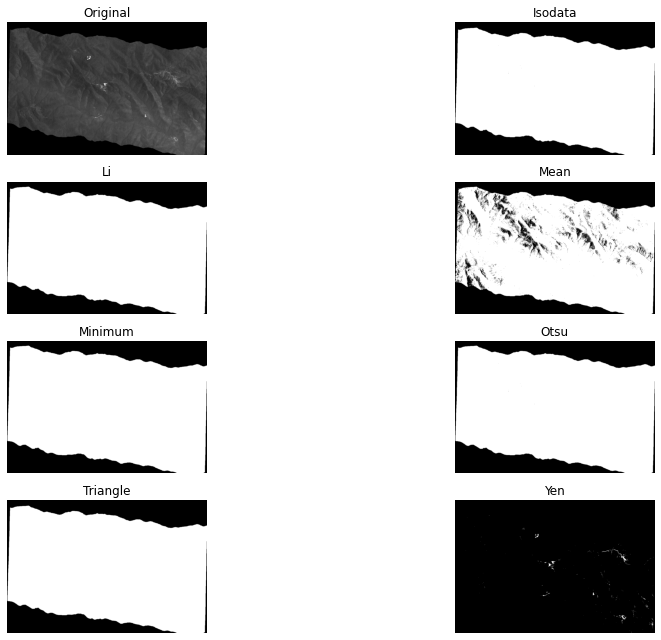

In [17]:
# Try all thresholds
fig, ax = try_all_threshold(img, figsize=(16, 9), verbose=False)

plt.show();

Since Yen's method seems to have an acceptable performance, we'll keep it and compare it with other approaches.

For example, let's visualize an image example with Yen, Manual, Adaptive, Quickshift and other filter methods.

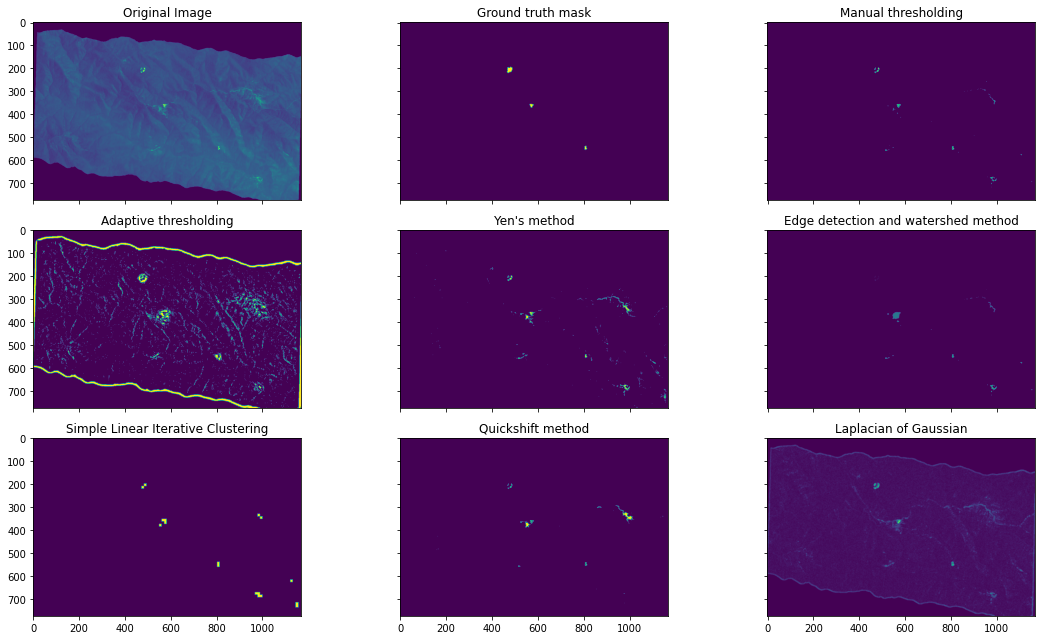

In [18]:
show_filters(img, true_mask)

Given the above example and our further experimentation, we used the Laplacian of Gaussian as the pre-processing step of choice before feeding the images into the model for training.

## Train Segmentation model

In [ ]:
# Define model
model, img_size, batch = print_model_menu()

In [ ]:
# Get training data
x_train, y_train = get_training_data(dc, linescan_datasets, gdf, plot=False)

# Path for checkpoint saving
filepath = "FPN-model-{f1-score:.3f}-{val_f1-score:.3f}.h5"

# Define optimizer
adam = tf.keras.optimizers.Adam(0.00001)

# Select a segmentation model loss function and evaluation metrics
jaccard_loss = sm.losses.JaccardLoss()
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# Define callbacks for learning rate scheduling and checkpoint saving
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath, save_weights_only=True, save_best_only=False,
                             mode='max', monitor='val_f1-score', verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=10, verbose=1)
]

# Define Image Generator
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=90,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.4, 1.2],
    validation_split=0.2
)


# Compile keras model with defined optimizer, loss and metrics
model.compile(optimizer=adam, loss=jaccard_loss, metrics=metrics)

In [ ]:
# Starts training the model on batches with data augmentation:
model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch,
                                 subset='training'),
                    validation_data=datagen.flow(x_train, y_train,
                                                 batch_size=batch, subset='validation'),
                    steps_per_epoch=math.ceil(len(x_train)/batch),
                    epochs=50, callbacks=callbacks)

### Visualize model's prediction

Use the trained model to predict the mask of an image and compare it with the ground-truth mask.

In [15]:
model = sm.FPN(backbone_name='vgg16', classes=1, activation='sigmoid',
                   encoder_weights=None, input_shape=(768, 768, 3))

model.load_weights('FPN-model-0.704-0.634.h5')

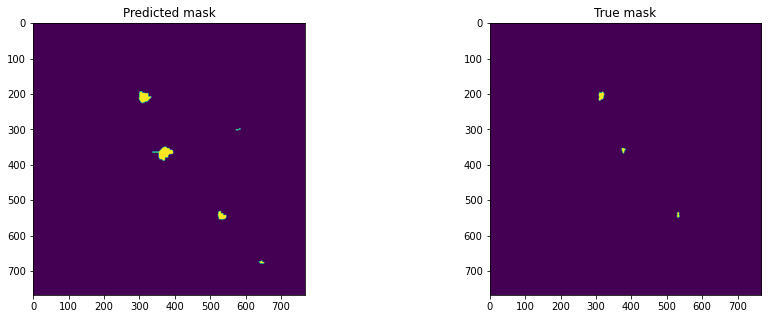

In [19]:
show_prediction(model, img, true_mask)

## Making a submission

Create a mask for each of the five linescans using the trained segmentation model.
Then transform the mask into a set of one or zero coordinates, where one indicates that coordinate is on fire, and zero indicates it is not.

In [20]:
# Load test set
test = pd.read_csv('resources/challenge1_test.csv', index_col='id')

print(test.shape)
test.head()

(5000, 6)


,label,x,y,dateTimeLocal,dateTimeUTC,target
id,,,,,,
0,JORDAN_235_P1_201901281204_MGA94_55,436123,5826713,28/01/2019 12:04,28/01/2019 1:04,NaN
1,JORDAN_235_P1_201901281204_MGA94_55,435924,5828006,28/01/2019 12:04,28/01/2019 1:04,NaN
2,JORDAN_235_P1_201901281204_MGA94_55,436458,5827661,28/01/2019 12:04,28/01/2019 1:04,NaN
3,JORDAN_235_P1_201901281204_MGA94_55,436166,5828564,28/01/2019 12:04,28/01/2019 1:04,NaN
4,JORDAN_235_P1_201901281204_MGA94_55,436283,5826144,28/01/2019 12:04,28/01/2019 1:04,NaN


Now we will loop over the test set of linescan images, and iterate over the test coordinates required in each image, filling the 'target' column of the test dataframe with the results of the masking predictions.

In [21]:
fnames = test.label.unique()
fnames

array(['JORDAN_235_P1_201901281204_MGA94_55',
       'JORDAN_294_P1_201902011150_MGA94_55',
       'WALHALLA_313_P1_201902020733_MGA94_55',
       'WALHALLA_353_P1_201902031625_MGA94_55',
       'MACALISTER91_648_P1_201903070444_MGA94_55'], dtype=object)

Initialize trained FPN model

In [22]:
model = sm.FPN(backbone_name='vgg16', classes=1, activation='sigmoid',
                   encoder_weights=None, input_shape=(768, 768, 3))

model.load_weights('FPN-model-0.704-0.634.h5')

Get predictions and apply post-processing using CV2.

In [23]:
final = make_submission(dc, test, fnames, model)